本案例采用`Olivetti Faces数据集`进行训练，构建一个深度为8的卷积神经网络对人脸进行识别，我们发现数据增强能够显著降低总体损失，提升神经网络性能。

# 目录
[1. 数据探索](#1)<br>
[2. 数据增强](#2)<br>
[3. 建立卷积神经网络模型 ](#3)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.1 定义评价函数](#3.1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.2  维数转换](#3.2)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.3 设计网络结构](#3.3)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.4 模型训练评估](#3.4)<br>
[4. 结果分析](#4)<br>

In [ ]:
# 如果有GPU，可以使用此代码
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

<div id="1"></div>
# 1 数据探索

Olivetti Faces是由纽约大学整理的一个人脸数据集，具体信息可以参考官网，该数据集包括40个人的400张图片，每个人的10张人脸图像都是在不同时间、光线和表情下采集的，每张图片的灰度级为8位，每个像素的灰度大小位于0-255之间，每张图片大小为64×64。


下面首先从sklearn的 datasets 中载入Olivetti Faces数据集：

In [20]:
% config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 加载人脸数据集
from sklearn.datasets import fetch_olivetti_faces
faces=fetch_olivetti_faces()

观察数据集结构组成：

In [2]:
faces

{'data': array([[0.30991736, 0.3677686 , 0.41735536, ..., 0.15289256, 0.16115703,
         0.1570248 ],
        [0.45454547, 0.47107437, 0.5123967 , ..., 0.15289256, 0.15289256,
         0.15289256],
        [0.3181818 , 0.40082645, 0.49173555, ..., 0.14049587, 0.14876033,
         0.15289256],
        ...,
        [0.5       , 0.53305787, 0.607438  , ..., 0.17768595, 0.14876033,
         0.19008264],
        [0.21487603, 0.21900827, 0.21900827, ..., 0.57438016, 0.59090906,
         0.60330576],
        [0.5165289 , 0.46280992, 0.28099173, ..., 0.35950413, 0.3553719 ,
         0.38429752]], dtype=float32),
 'images': array([[[0.30991736, 0.3677686 , 0.41735536, ..., 0.37190083,
          0.3305785 , 0.30578512],
         [0.3429752 , 0.40495867, 0.43801653, ..., 0.37190083,
          0.338843  , 0.3140496 ],
         [0.3429752 , 0.41735536, 0.45041323, ..., 0.38016528,
          0.338843  , 0.29752067],
         ...,
         [0.21487603, 0.20661157, 0.2231405 , ..., 0.15289256,
     

观察发现，该数据集包括四部分：<br>
1）`DESCR` 主要介绍了数据的来源；<br>
2）`data` 以一维向量的形式存储了数据集中的400张图像；<br>
3）`images` 以二维矩阵的形式存储了数据集中的400张图像；<br>
4）`target` 存储了数据集中400张图像的类别信息，以0-39分别代表40个人。<br>

下面进一步观察数据的结构与类型：

In [3]:
print("The shape of data:",faces.data.shape, "The data type of data:",type(faces.data))
print("The shape of images:",faces.images.shape, "The data type of images:",type(faces.images))
print("The shape of target:",faces.target.shape, "The data type of target:",type(faces.target))

The shape of data: (400, 4096) The data type of data: <class 'numpy.ndarray'>
The shape of images: (400, 64, 64) The data type of images: <class 'numpy.ndarray'>
The shape of target: (400,) The data type of target: <class 'numpy.ndarray'>


所有的数据都以 numpy.ndarray 形式存储，利用起来很方便，因为下一步我们希望搭建卷积神经网络CNN来实现人脸识别，所以特征要用二维矩阵存储的图像，这样可以充分挖掘图像的结构信息。


下面我们进一步观察一组样本图像：

This is the first person:


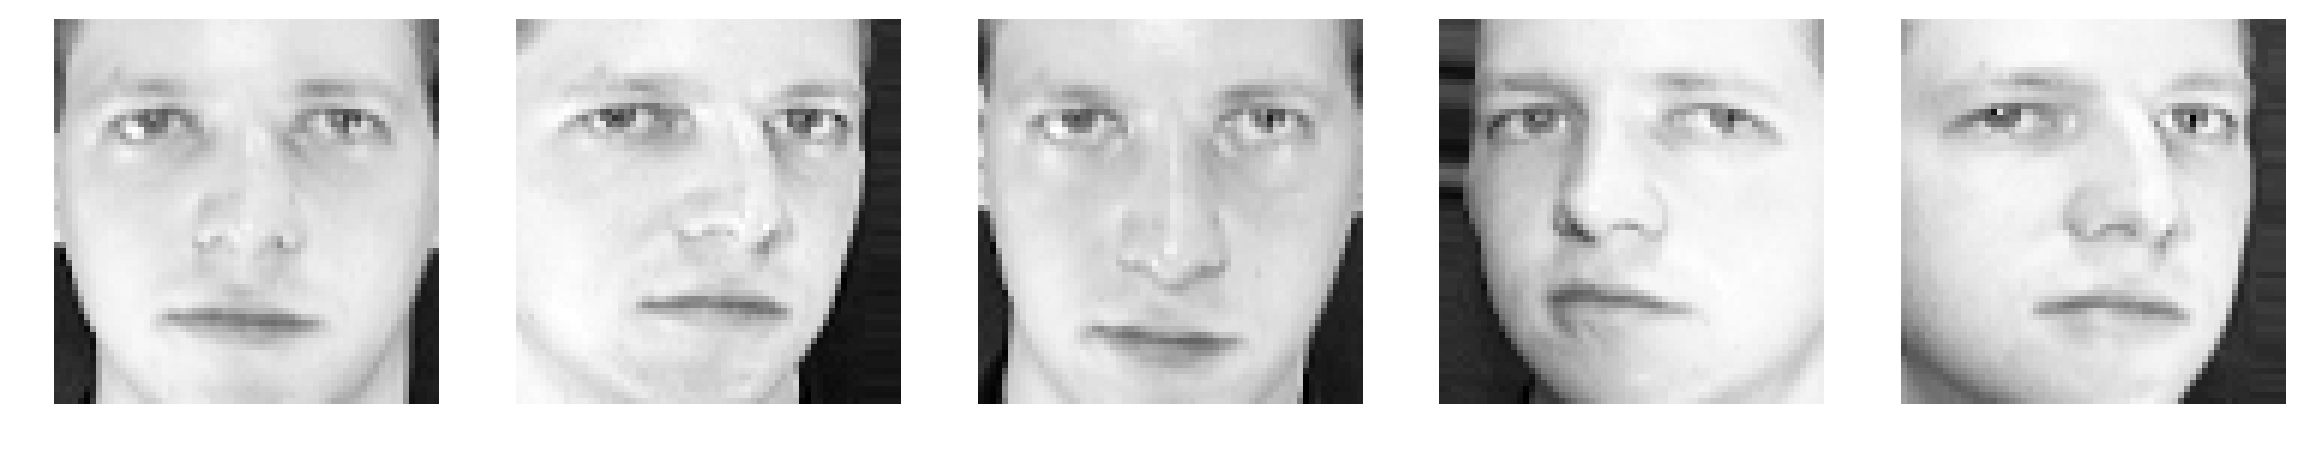

This is the second person:


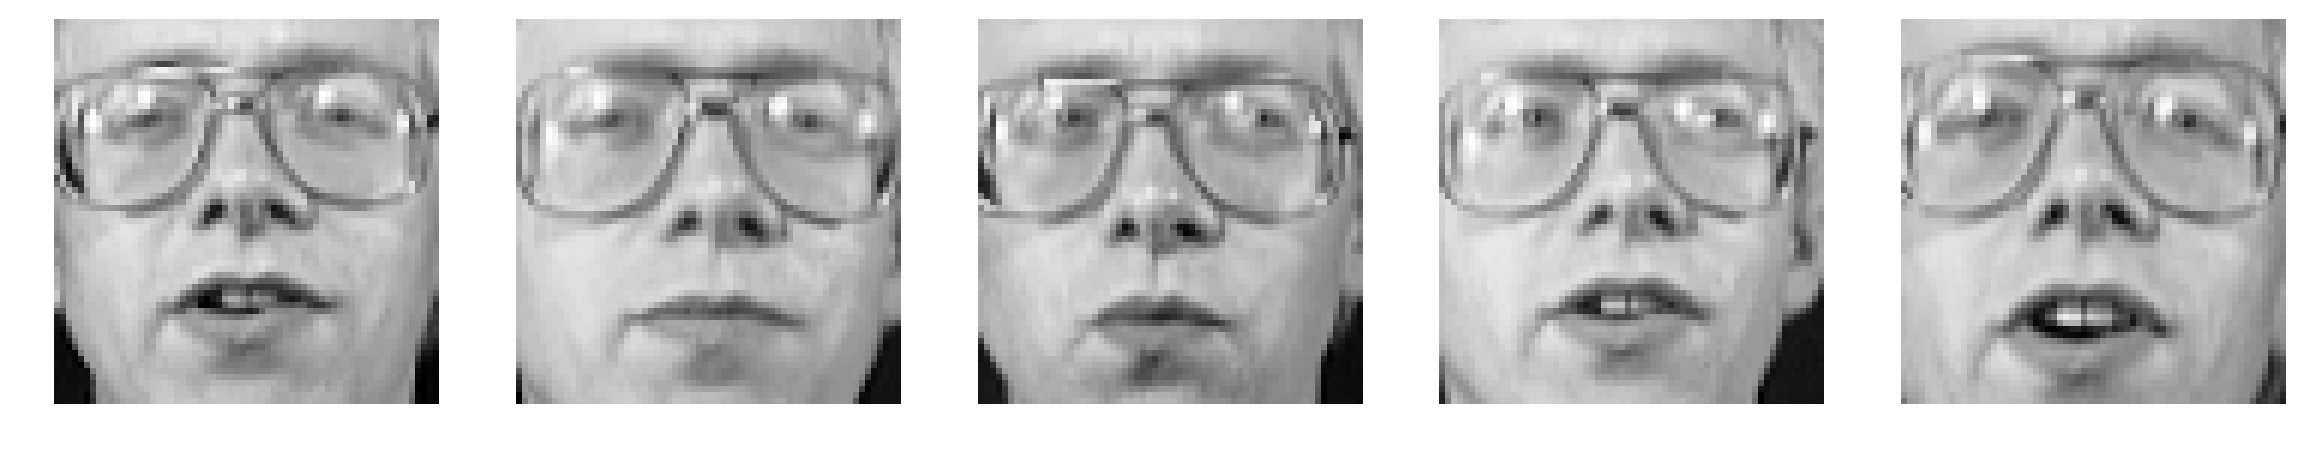

This is the third person:


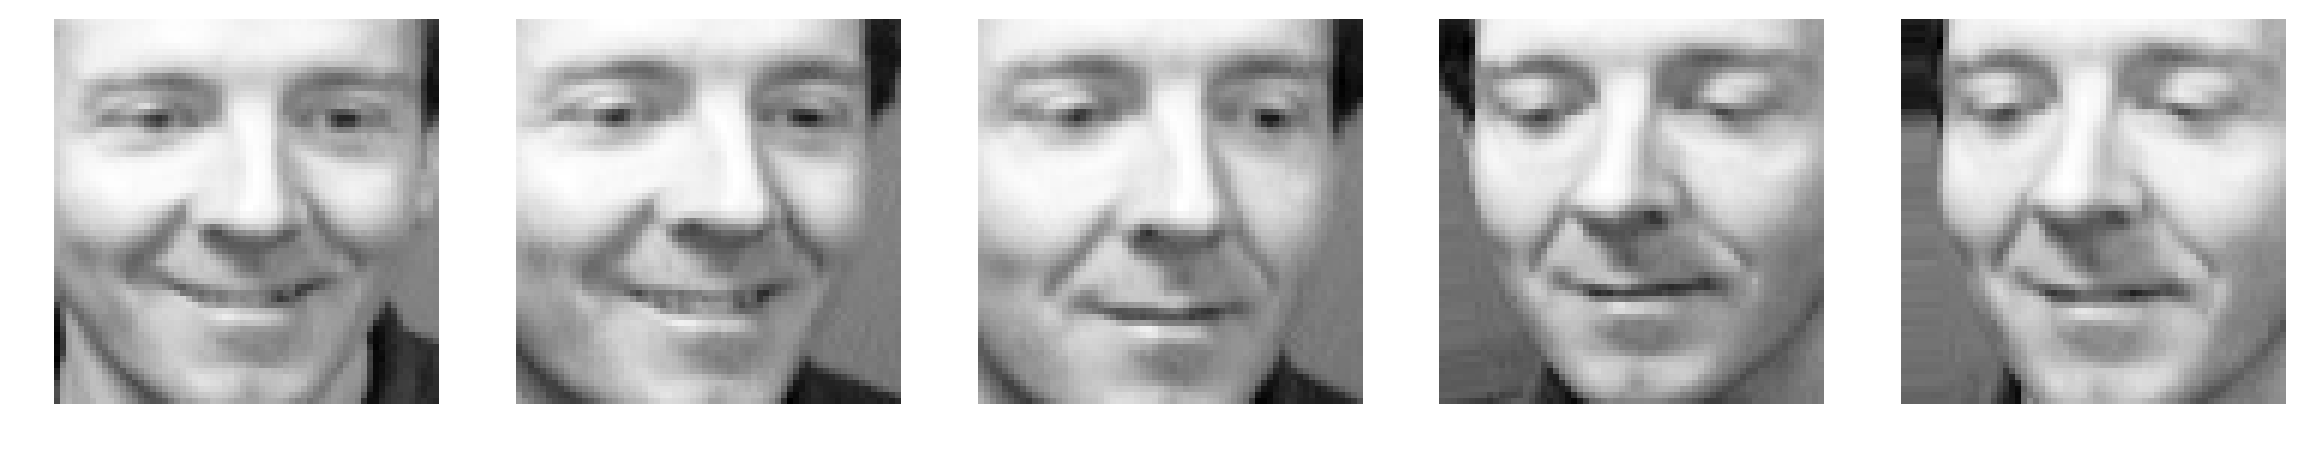

In [21]:
for i in range(3):
    fig=plt.figure(figsize=(20,5))
    count=1
    if i==0:
        print("This is the first person:")
    if i==1:
        print("This is the second person:")
    if i==2:
        print("This is the third person:")
    for j in range(5):
        ax1=fig.add_subplot(1,5,count)
        count += 1
        plt.imshow(faces.images[10*i+j],cmap="Greys_r")     # 显示图片
        plt.axis('off')                                     # 不显示坐标轴
    plt.show()      

观察发现，每一个人的不同图像都存在角度、表情、光线的区别，这种样本之间的差异性虽然提升了分类难度，但同时要求模型必须提取到人脸的高阶特征，增强了模型的泛化能力。

<div id="2"></div>
# 2 数据增强

首先划分训练集与测试集：

In [22]:
# 定义特征和标签
x=faces.images
y=faces.target

# 以8:2比例随机地划分训练集和测试集
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

# 记录测试集中出现的类别，后期模型评价画混淆矩阵时需要
index=set(test_y)

在做数据增强前，需要先把二维图像转换为三通道的图像，因为keras中的 flow 函数只接受三通道的图像输入，一般的RGB图像都附有三种原色通道：红、绿、蓝，而灰度图像则只有一种通道，当需要把灰度图像转换为三通道RGB图像时，只需要在其三个通道上都用原始灰度像素填充。


在下面的循环块中，我们借助了 tqdm 进度条库来即时展示循环块的运行进程，这可以使我们了解到程序是否在顺利运行，对于计算复杂度高的循环十分有用。

In [23]:
import tqdm

# 定义列表train_x_RGB来存储转换的三通道图像
train_x_RGB=[]

# 利用tqdm输出运行进程
for k in tqdm.tqdm(range(len(train_x))):
    
    # 定义三维数组来存储转换后的三通道图像
    image_RGB=np.empty((64,64,3))
    
    # 用灰度像素填充三通道
    for i in range(64):
        for j in range(64):
            image_RGB[i][j]=train_x[k][i][j]
    train_x_RGB.append(image_RGB)
train_x_RGB=np.array(train_x_RGB)

100%|███████████████████████████████████████████████████████████████████████████████| 320/320 [00:02<00:00, 156.80it/s]


In [9]:
print(train_x_RGB.shape)

(320, 64, 64, 3)


每张图像的维度已经变成了(64, 64, 3)，说明已经成功转换为三通道图像。


在深度学习中，为了防止过拟合，我们通常需要足够的数据，当无法得到充分大的数据量时，可以通过图像的几何变换来增加训练数据的量。为了充分利用有限的训练集（只有320个样本），我们将通过一系列随机变换增加训练数据，以防止过拟合、提升模型泛化能力。

In [25]:
from keras.preprocessing.image import ImageDataGenerator

# 定义随机变换的类别及程度
datagen = ImageDataGenerator(
        rotation_range=0,            # 图像随机转动的角度
        width_shift_range=0.01,      # 图像水平偏移的幅度
        height_shift_range=0.01,     # 图像竖直偏移的幅度
        shear_range=0.01,            # 逆时针方向的剪切变换角度
        zoom_range=0.01,             # 随机缩放的幅度
        horizontal_flip=True,
        fill_mode='nearest')

for i in tqdm.tqdm(range(len(train_x_RGB))):
    img = train_x_RGB[i]
    img = img.reshape((1,) + img.shape)  # 维数转换
    count = 0
    for batch in datagen.flow(img,batch_size=1,
                        save_to_dir="E:\\face",    # 生成后的图像保存路径
                        save_prefix=str(train_y[i]),     # 生成后图像用其标签命名，这样方便记录其种类
                        save_format='png'):
        count += 1
        if count >= 3:                  # 只保存扩增的前3个图像
            break  

100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:05<00:00, 61.33it/s]


读取增强后的训练集：

In [26]:
import os
import tqdm
import matplotlib.image as mpimg

# 读取训练集数据
train_x_enhance = []               
train_y_enhance = []

fileDir = r"E:\face"                  # 数据所在的文件夹
for root, dirs, files in os.walk(fileDir): 

    for name in tqdm.tqdm(files):
        path = str(root+ '/' + name)           # 路径
        photo = mpimg.imread(path)             # 读取图像
        photo_2D = photo[:,:,0]                # 增强后的图像是三通道的，切片读取为二维矩阵
        train_x_enhance.append(photo_2D)     # 添加训练集数据
        train_y_enhance.append(int(name.split("_")[0])) # 通过字符串切割得到类别信息

train_x_enhance = np.array(train_x_enhance)
train_y_enhance = np.array(train_y_enhance)      

100%|██████████████████████████████████████████████████████████████████████████████| 959/959 [00:00<00:00, 1773.62it/s]


<div id="3"></div>
# 3 建立卷积神经网络模型

<div id="3.1"></div>
## 3.1 定义评价函数

In [27]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report 

"""
函数evaluate(pred,test_y)用来对分类结果进行评价；
输入：真实的分类、预测的分类结果
输出：分类的准确率、混淆矩阵等
"""
def evaluate(pred,test_y):
    # 将三维的分类结果转换成一维数组
    pred_1D = []
    for i in range(len(pred)):
        some = list(pred[i])
        max_index = some.index(max(some))  #记录最大值的index
        pred_1D.append(max_index)
    pred_1D=np.array(pred_1D)
    
    # 将三维的分类结果转换成一维数组
    testy_1D = []
    for i in range(len(test_y)):
        some = list(test_y[i])
        max_index = some.index(max(some))  #记录最大值的index
        testy_1D.append(max_index)
    testy_1D = np.array(testy_1D)
    
    # 输出分类的准确率
    print("Accuracy: %.4f"  % (metrics.accuracy_score(testy_1D,pred_1D)))
    # 输出衡量分类效果的各项指标
    print(classification_report(testy_1D, pred_1D)) 
    # 更直观的，我们通过seaborn画出混淆矩阵
    %matplotlib inline
    plt.figure(figsize=(9,6))
    colorMetrics = metrics.confusion_matrix(testy_1D,pred_1D)
    # 坐标y代表test_y，即真实的类别，坐标x代表估计出的类别pred
    sns.heatmap(colorMetrics,annot=True,fmt='d',xticklabels=list(index),yticklabels=list(index))
    sns.plt.show()

<div id="3.2"></div>
## 3.2 维数转换

keras对输入数据的格式有严格要求：<br>
1）一维卷积层 `Conv1D` 输入三维数组，二维卷积层 `Conv2D` 输入四维数组；<br>
2）label必须是one-hot变量。<br>

In [28]:
from keras.utils import np_utils

# 对特征的转换：由3维转换为4维
train_x=train_x.reshape(train_x.shape + (1,))
train_x_enhance=train_x_enhance.reshape(train_x_enhance.shape + (1,))
test_x=test_x.reshape(test_x.shape + (1,))

# 对标签的转换：one-hot编码
train_y= np_utils.to_categorical(train_y, 40)
train_y_enhance= np_utils.to_categorical(train_y_enhance, 40)
test_y= np_utils.to_categorical(test_y, 40)

<div id = "3.3"></div>
## 3.3 设计网络结构

从keras的相应模块引入需要的对象：

In [29]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten 
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam

定义网络结构：

In [30]:
# 定义种子使参数初始化一致，从而实验可重复
seed = 100
np.random.seed(seed)

# 开始定义一个模型
model = Sequential()  

# 添加一个卷积层，卷积核有32个，卷积核大小为（3，3），valid指卷积核只遍历有完整结构的数据
# input_shape最后一维为1代表输入是灰度图片，3代表彩色RGB图片
model.add(Conv2D(32, 3, 3, border_mode='valid', input_shape=(64, 64, 1)))  
model.add(Activation('relu')) 

# 添加池化窗口为（2，2）的最大池化层
model.add(MaxPooling2D(pool_size=(2, 2)))  
  
# 添加一个卷积层，卷积核有64个，卷积核大小为（3，3）
model.add(Conv2D(64, 3, 3))  
model.add(Activation('relu')) 

# 添加池化窗口为（2，2）的最大池化层
model.add(MaxPooling2D(pool_size=(2, 2))) 

# 添加Dropout层防止过拟
# Dropout将在训练过程中每次更新参数时随机断开一定比率的输入神经元
model.add(Dropout(0.25)) 

# 添加Flatten层把多维的输入一维化
# Flatten层常用在从卷积层到全连接层的过渡
model.add(Flatten())  

# 添加有512个节点的全连接层
model.add(Dense(512))  
model.add(Activation('tanh'))

# 添加softmax输出层
model.add(Dense(40))  
model.add(Activation('softmax'))  

# 定义损失函数与优化器
# 'categorical_crossentropy'用于多分类问题，优化器选择Adam
model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])

W0721 19:30:53.184902 88176 deprecation_wrapper.py:119] From C:\Users\Administrator\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(64, 64, 1..., padding="valid")`
  # Remove the CWD from sys.path while we load stuff.
W0721 19:30:53.233856 88176 deprecation_wrapper.py:119] From C:\Users\Administrator\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0721 19:30:53.246849 88176 deprecation_wrapper.py:119] From C:\Users\Administrator\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0721 19:30:53.301818 8

<div id="3.4"></div>
## 3.4 模型训练与评估

用原始数据训练模型：

In [31]:
# 训练模型
model.fit(train_x, train_y, batch_size=200, nb_epoch=20, validation_data=(test_x,test_y))

# 模型评价
score = model.evaluate(test_x, test_y, batch_size=20)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  
W0721 19:31:03.137534 88176 deprecation.py:323] From C:\Users\Administrator\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 320 samples, validate on 80 samples
Epoch 1/20
320/320 [==============================] - ETA: 1s - loss: 3.6889 - acc: 0.015 - 3s 11ms/step - loss: 3.8770 - acc: 0.0187 - val_loss: 3.9457 - val_acc: 0.0000e+00
Epoch 2/20
320/320 [==============================] - ETA: 0s - loss: 3.6224 - acc: 0.050 - 2s 6ms/step - loss: 3.6311 - acc: 0.0438 - val_loss: 3.6370 - val_acc: 0.0750
Epoch 3/20
320/320 [==============================] - ETA: 0s - loss: 3.5033 - acc: 0.170 - 2s 6ms/step - loss: 3.4938 - acc: 0.1781 - val_loss: 3.4921 - val_acc: 0.2125
Epoch 4/20
320/320 [==============================] - ETA: 0s - loss: 3.3512 - acc: 0.255 - 2s 6ms/step - loss: 3.3465 - acc: 0.2375 - val_loss: 3.3841 - val_acc: 0.3000
Epoch 5/20
320/320 [==============================] - ETA: 0s - loss: 3.1803 - acc: 0.500 - 2s 6ms/step - loss: 3.1453 - acc: 0.5094 - val_loss: 3.2406 - val_acc: 0.3500
Epoch 6/20
320/320 [==============================] - ETA: 0s - loss: 2.9059 - acc: 0.685 - 2s 6ms/s

更详细的模型评价：

Accuracy: 0.9000


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       1.00      1.00      1.00         4
           2       0.50      0.50      0.50         2
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       0.67      0.67      0.67         3
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         2
          14       0.80      1.00      0.89         4
          15       1.00      1.00      1.00         3
          17       1.00      0.50      0.67         6
          19       1.00      1.00      1.00         3
          20       0.50    

AttributeError: module 'seaborn' has no attribute 'plt'

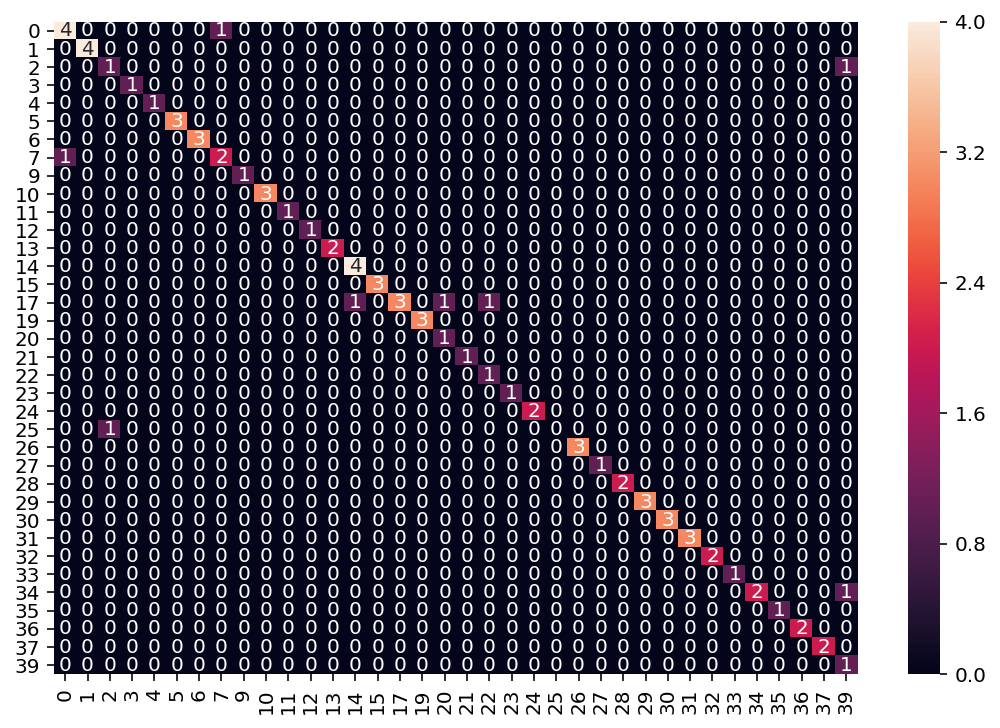

In [32]:
pred=model.predict(test_x)
evaluate(pred,test_y)

用原始数据训练模型，能达到90%的准确率，其中错误较多的是把第17人识别为第22人、把第34人识别为第39人。


用增强后的数据训练模型：


需要注意：在重新训练模型之前，必须重新初始化模型参数，不然会从上次的训练结果开始迭代，导致出错。

In [33]:
# 训练模型
model.fit(train_x_enhance, train_y_enhance, batch_size=200, nb_epoch=20, validation_data=(test_x,test_y))

# 模型评价
score = model.evaluate(test_x, test_y, batch_size=20)
print('Test score:', score[0])
print('Test accuracy:', score[1])

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 959 samples, validate on 80 samples
Epoch 1/20
959/959 [==============================] - ETA: 4s - loss: 0.4219 - acc: 0.855 - ETA: 3s - loss: 0.3826 - acc: 0.870 - ETA: 1s - loss: 0.4437 - acc: 0.871 - ETA: 0s - loss: 0.4838 - acc: 0.858 - 6s 6ms/step - loss: 0.4541 - acc: 0.8686 - val_loss: 0.6291 - val_acc: 0.8375
Epoch 2/20
959/959 [==============================] - ETA: 4s - loss: 0.4150 - acc: 0.905 - ETA: 3s - loss: 0.3811 - acc: 0.907 - ETA: 2s - loss: 0.3151 - acc: 0.920 - ETA: 0s - loss: 0.3101 - acc: 0.925 - 6s 6ms/step - loss: 0.2903 - acc: 0.9291 - val_loss: 0.4214 - val_acc: 0.8750
Epoch 3/20
959/959 [==============================] - ETA: 3s - loss: 0.1312 - acc: 0.975 - ETA: 3s - loss: 0.1460 - acc: 0.972 - ETA: 2s - loss: 0.1538 - acc: 0.968 - ETA: 0s - loss: 0.1391 - acc: 0.971 - 6s 6ms/step - loss: 0.1343 - acc: 0.9729 - val_loss: 0.2688 - val_acc: 0.9125
Epoch 4/20
959/959 [==============================] - ETA: 4s - loss: 0.0766 - acc: 1.000 - ETA: 3s - l

更详细的模型评价：

Accuracy: 0.9250


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         3
           6       1.00      0.67      0.80         3
           7       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         2
          14       0.80      1.00      0.89         4
          15       1.00      1.00      1.00         3
          17       1.00      0.50      0.67         6
          18       0.00      0.00      0.00         0
          19       1.00    

AttributeError: module 'seaborn' has no attribute 'plt'

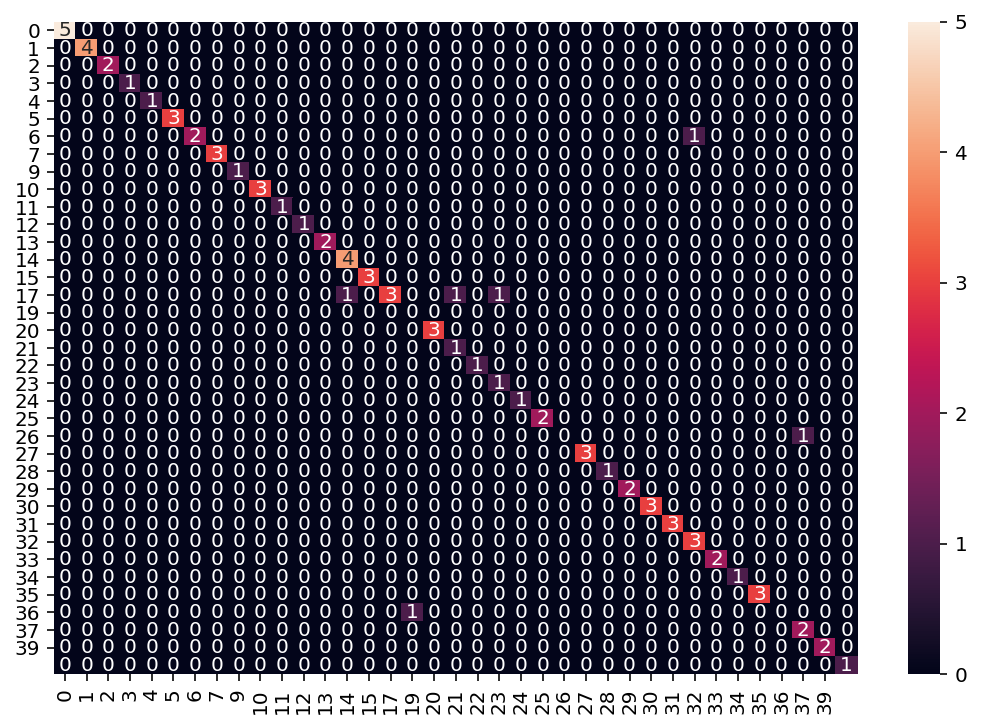

In [34]:
pred=model.predict(test_x)
evaluate(pred,test_y)

同样的模型结构，增强数据能达到93.75%的准确率，即使识别错误，也最多错一次。

<div id="4"></div>
# 4 结果分析

画出柱状图直观展示两个模型的差异：

model|loss|accuracy|precision|recall|f1-score
-|-|-|-|-|-
model_original|0.571|0.900|0.93|0.90|0.90
model_enhance|0.291|0.938|0.94|0.94|0.93

<Figure size 576x432 with 0 Axes>

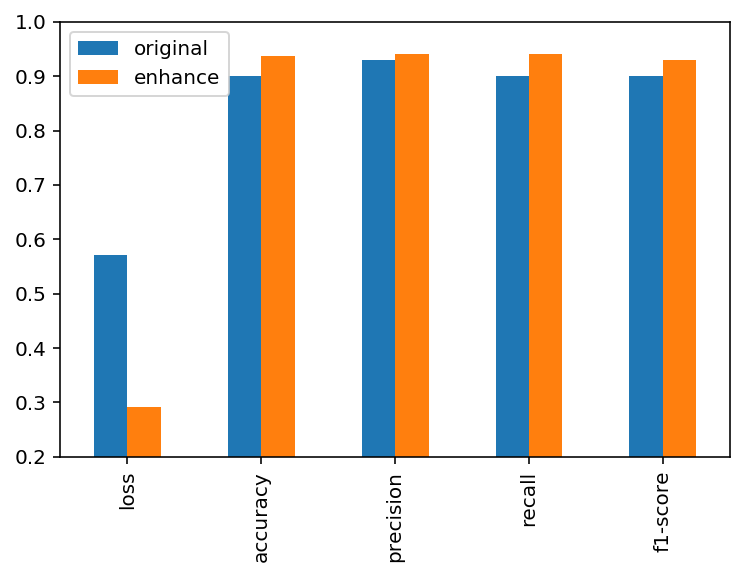

In [35]:
index=["loss","accuracy","precision","recall","f1-score"]
data=np.array([[0.571,0.291],[0.900,0.938],[0.93,0.94],[0.90,0.94],[0.90,0.93]])
df=pd.DataFrame(data,columns=["original","enhance"],index=index)
plt.figure(figsize=(8,6))
df.plot(kind="bar")
plt.ylim([0.2,1])
plt.show()

数据增强后的模型效果明显好于原始数据模型，这是因为训练数据的增多能降低过拟合，当遇到数据量较小的数据集时，应该优先考虑这种方法。